In [33]:
from pathlib import Path
import pandas as pd
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
### load original daic data
def load_original_daic(file_path, file_type):
    """TODO
    file_type: AUs, features, gaze, pose
    """
    if not Path.exists(file_path):
        print("Directory does not exist. Check input feature directory")
    loaded_features = {}
    for participant_id in range(300, 500):
        full_path = file_path / (participant_id + "_CLNF_" + file_type)
        participant_df = pd.read_csv(full_path, sep=",")
        participant_df.columns = participant_df.columns.str.replace(" ", "")
        participant_df.drop(columns=["frame", "timestamp", "confidence", "success"])
        loaded_features[participant_id] = participant_df
    if not loaded_features:
        print(
            "No samples loaded, check the samples are available in the input directory."
        )
    return loaded_features

In [ ]:
daic_pose_train = load_original_daic("original_daic/train", "pose")
daic_pose_dev = load_original_daic("original_daic/dev", "pose")
daic_pose_test = load_original_daic("original_daic/test", "pose")

In [ ]:
label_path = Path("original_daic/labels")
loaded_labels = {
    "dev": [], 
    "train": [], 
    "test": [],
    }
paths = {
    "dev": label_path / "dev_split_Depression_AVEC2017.csv",
    "train": label_path / "train_split_Depression_AVEC2017.csv",
    "test": label_path / "test_split_Depression_AVEC2017.csv",
}
for subset, path in paths.items():
    subset_df = pd.read_csv(path)
    subset_dict = subset_df.to_dict()
    for i in range(len(subset_dict["Participant_ID"])):
        participant = str(subset_dict["Participant_ID"][i])
        loaded_labels[subset].append(subset_dict["PHQ_Binary"])
        # to reimplement this code would require initilisation 
        # of loaded labels as a dict of dicts
        # loaded_labels[subset][participant] = {
        #     "PHQ_Binary": subset_dict["PHQ_Binary"][i],
        #     "PHQ_Score": subset_dict["PHQ_Score"][i],
        # }
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])


In [ ]:
pose_train = []
pose_dev = []
pose_test = []
for subject_id, subject_df in daic_pose_train.items():
    temp = subject_df.copy().loc[0:4999].to_numpy()
    pose_train.append(temp)
for subject_id, subject_df in daic_pose_dev.items():
    temp = subject_df.copy().loc[0:4999].to_numpy()
    pose_dev.append(temp)
for subject_id, subject_df in daic_pose_test.items():
    temp = subject_df.copy().loc[0:4999].to_numpy()
    pose_test.append(temp)

In [32]:
# list1 = [np.array([12,1]), np.array([2,3])]
# list2 = [np.array([4,5]), np.array([6,7])]
# list3 = [np.array([8,9]), np.array([10,11])]
# all_lists = np.array(list1 + list2 + list3)
# print(all_lists.min(0))
# print(all_lists.ptp(0))
all_samples = np.array(pose_train + pose_dev + pose_test)
min_values = all_samples.min(axis=0)
ptp_ranges = all_samples.ptp(axis=0)

[2 1]
[10 10]


In [ ]:
pose_train = np.array(pose_train)
pose_dev = np.array(pose_dev)
pose_test = np.array(pose_test)

In [ ]:
norm_pose_train = (pose_train - min_values)/ptp_ranges
norm_pose_dev = (pose_dev - min_values)/ptp_ranges
norm_pose_test = (pose_test - min_values)/ptp_ranges

In [34]:
input_pose = Input(shape=[5000, 6])
# tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
tdcn_dim_pose = [128,128,128,128,128]
bias_initializer = HeNormal(seed=0)

In [35]:
x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
print(x_train_bad.shape)
print(y_train_bad.shape)

(400, 5000, 6)
(400,)


In [36]:
# One DCB
# first layer of the DCB
def diluted_conv_block(inputs, feature_dim):
    # with K.name_scope(block_name)
    l1_p1 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_p2 = Conv1D(filters=feature_dim, kernel_size=3, padding="same", dilation_rate=1, use_bias=True, bias_initializer=bias_initializer)(inputs)
    l1_add = Add()([l1_p1, l1_p2])
    l1_ELU = ELU()(l1_add)
    # second layer of the DCB
    l2_p1 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_p2 = Conv1D(filters=feature_dim, kernel_size=5, padding="same", dilation_rate=2, use_bias=True, bias_initializer=bias_initializer)(l1_ELU)
    l2_add = Add()([l2_p1, l2_p2])
    l2_ELU = ELU()(l2_add)
    # third layer of the DCB
    l3_p1 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_p2 = Conv1D(filters=feature_dim, kernel_size=9, padding="same", dilation_rate=4, use_bias=True, bias_initializer=bias_initializer)(l2_ELU)
    l3_add = Add()([l3_p1, l3_p2])
    l3_ELU = ELU()(l3_add)

    residual = Conv1D(filters=feature_dim, kernel_size=1, padding="same")(inputs)
    res_add = Add()([l3_ELU, residual])
    # res_add = Add()([l1_ELU, residual])
    # res_add = ELU()(res_add)
    # bn = BatchNormalization()(res_add)
    return res_add
    # return residual

In [54]:
def time_diluted_conv_net(feature_dim, input_layer, pool_size, pool_stride):
    dcb_1 = diluted_conv_block(input_layer, feature_dim[0])
    mp_1 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_1)
    dcb_2 = diluted_conv_block(mp_1, feature_dim[1])
    mp_2 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_2)
    dcb_3 = diluted_conv_block(mp_2, feature_dim[2])
    mp_3 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_3)
    dcb_4 = diluted_conv_block(mp_3, feature_dim[3])
    mp_4 = MaxPooling1D(pool_size=pool_size, strides=pool_stride, padding='valid')(dcb_4)
    dcb_5 = diluted_conv_block(mp_4, feature_dim[4])
    return dcb_5
    # return dcb_2

# TDCN block for pose
tdcn_pose = time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose])
print(concat_layer.shape)
# gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(tdcn_pose)
print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
# relu_layer = Dense(128, activation = "relu")(linear_layer_1)
relu_layer = activations.relu(linear_layer_1)
# relu_layer = ReLU()(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
# sigmoid_layer = Dense(128, activation = "sigmoid")(linear_layer_2)
sigmoid_layer = activations.sigmoid(linear_layer_2)
# reshape_layer = Reshape((312, 128),)(sigmoid_layer)
# print(reshape_layer.output_shape)
# elementwise_product = Multiply()([concat_layer, reshape_layer])
# elementwise_product = Multiply()([concat_layer, sigmoid_layer])
elementwise_product = Multiply()([tdcn_pose, sigmoid_layer])

# FC layer
flatten = Flatten()(elementwise_product)
FC_l1 = Dense(100, activation = "relu")(flatten)
FC_l2 = Dense(100, activation = "relu")(FC_l1)
FC_l3 = Dense(100, activation = "relu")(FC_l2)
last_layer = Dense(2, activation = "sigmoid")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 128)
(None, 128)


In [55]:
model_pose = Model(inputs=[input_pose], outputs=[output])
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_pose.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])

In [56]:
model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=5)
# model_pose.fit(pose_train[:], y_train[:], validation_data=(pose_dev[:], y_dev[:]), epochs=5)

Epoch 1/5
13/13 [==============================] - 62s 5s/step - loss: 0.6952 - accuracy: 0.5000 - val_loss: 0.6938 - val_accuracy: 0.5000
Epoch 2/5
13/13 [==============================] - 59s 5s/step - loss: 0.6934 - accuracy: 0.7550 - val_loss: 0.6932 - val_accuracy: 1.0000
Epoch 3/5
13/13 [==============================] - 59s 5s/step - loss: 0.6932 - accuracy: 0.5775 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
13/13 [==============================] - 59s 5s/step - loss: 0.6932 - accuracy: 0.3675 - val_loss: 0.6932 - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 58s 4s/step - loss: 0.6932 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.0000e+00


2/2 [==============================] - 2s 347ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


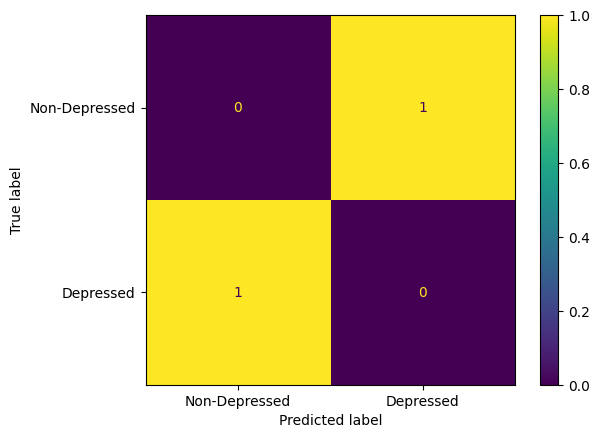

Accuracy = 0.0
Recall = 0.0
Precision = 0.0
F1-score = nan


C:\Users\u1737136\AppData\Local\Temp\ipykernel_22512\2875687946.py:21: RuntimeWarning: invalid value encountered in double_scalars
  f1_score = 2 * precision * recall / (precision + recall)


In [58]:
#Predict
# y_pose_prediction = model_pose.predict(pose_test)
y_pose_prediction = model_pose.predict(x_dev_bad)
y_pose_prediction = np.argmax(y_pose_prediction, axis = 1)
# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
# result = confusion_matrix(y_test, y_pose_prediction, normalize='pred')
result = confusion_matrix(y_dev_bad, y_pose_prediction, normalize='pred')
# print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))